### import Dependence

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import shutil
import os
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , regularizers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import to_categorical

### Load Dataset

In [39]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [40]:
main_folder = r'/kaggle/input/brain-tumor-mri-dataset/Training'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

#Get images grouped by folder

folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) if img.endswith(('.jpg','.png','.webp'))]
    random.shuffle(images) #Shuffle image within each folder
    folder_images[folder]= images

#Round-robin selection
selected_images=[]
folder_cycle = cycle(subfolders) # infinte loop through folders
while len(selected_images)<16:
    folder = next(folder_cycle)
    if folder_images[folder]: #if folder still has images
        selected_images.append(folder_images[folder].pop())


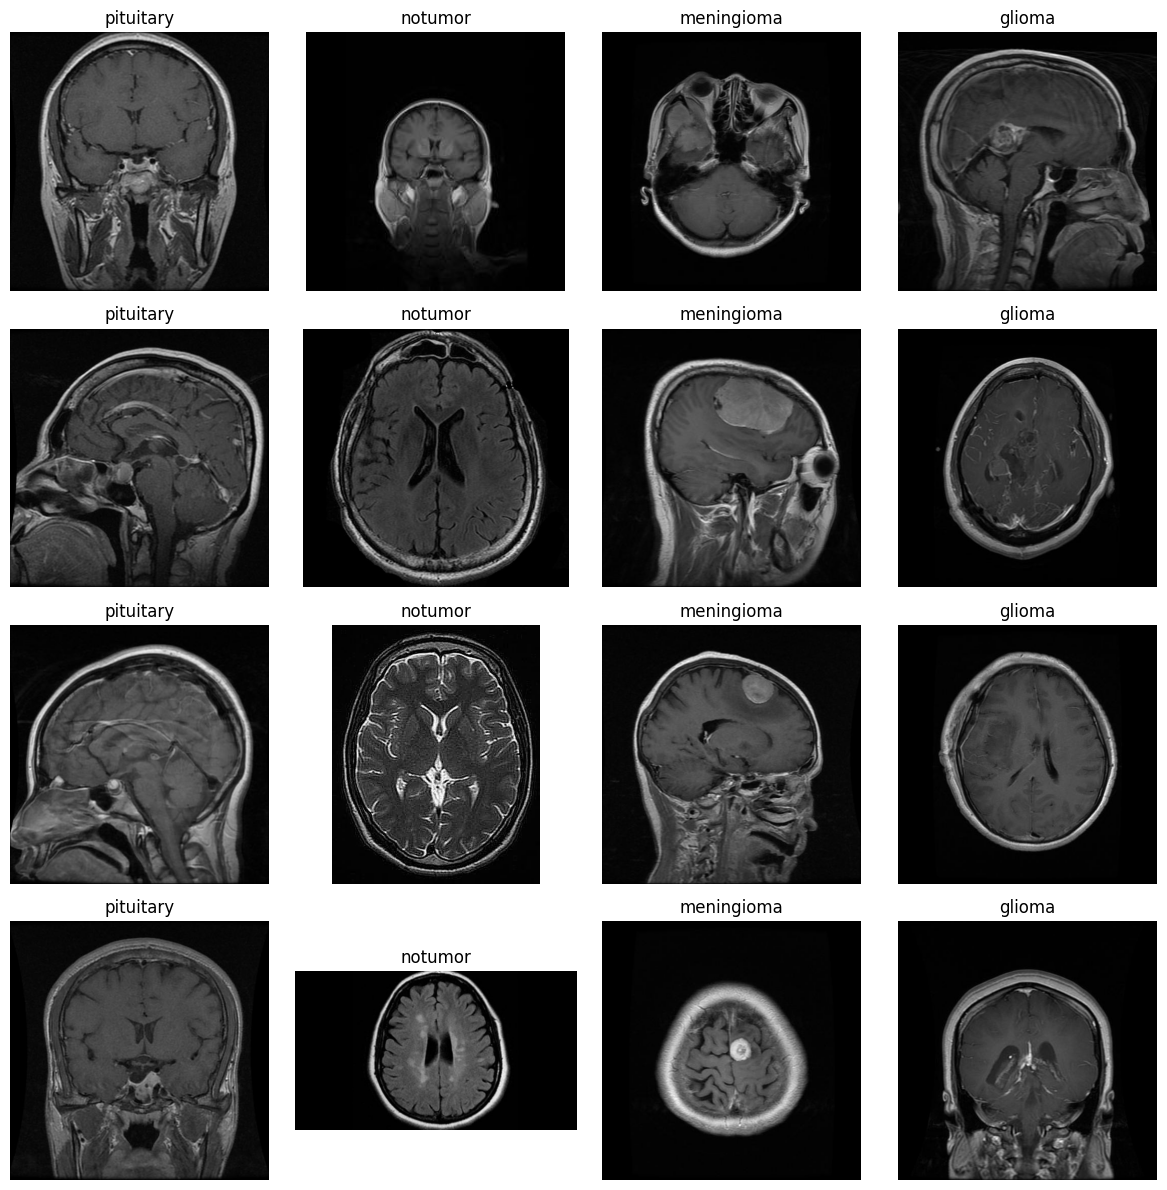

In [41]:
#plot them
plt.figure(figsize=(12,12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(4,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path))) #show folder name
plt.tight_layout()
plt.show()

In [42]:
ain_folder = r'/kaggle/input/brain-tumor-mri-dataset/Testing'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())


### Data Preprocessing

In [45]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [46]:
def cnn_preprocess(x):
    return x/255.0

In [47]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
    train_path,
    target_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.


In [48]:
cnn_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [49]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function= cnn_preprocess)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical'
)

Found 1311 images belonging to 4 classes.


In [50]:
cnn_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

### CNN Model Building

In [13]:
cnn_model = keras.Sequential([
    
    Conv2D(filters=64, kernel_size=(3,3),padding="same",
    activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
    Conv2D(filters=64, kernel_size=(3,3),padding="same",
    activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=128, kernel_size=(3,3),padding="same",
    activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
    Conv2D(filters=128, kernel_size=(3,3),padding="same",
    activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=256, kernel_size=(3,3),padding="same",
    activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.4),

    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),

    Dense(units=len(cnn_test_generator.class_indices), activation='softmax', dtype='float32')
                                    
])

I0000 00:00:1752732486.406753      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,977,220 (198.28 MB)

 Trainable params: 51,977,220 (198.28 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath='CCN.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [16]:
cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',metrics=['accuracy',keras.metrics.Precision(name='precision'),
                                   keras.metrics.Recall(name='recall'),
                                   keras.metrics.F1Score(name='f1_score')
                                                         ])

In [17]:
cnn_history = cnn_model.fit(
    cnn_train_generator,
    epochs= 20,
    validation_data = cnn_test_generator,
    callbacks = callbacks
)

Epoch 1/20


I0000 00:00:1752732493.546379     111 service.cc:148] XLA service 0x7af9780051e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752732493.547169     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752732494.079301     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/179 ━━━━━━━━━━━━━━━━━━━━ 57:03 19s/step - accuracy: 0.1875 - f1_score: 0.0909 - loss: 1.3886 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1752732507.565430     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5474 - f1_score: 0.5045 - loss: 0.9567 - precision: 0.8012 - recall: 0.3867
Epoch 1: val_loss improved from inf to 0.67515, saving model to CCN.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 379ms/step - accuracy: 0.5482 - f1_score: 0.5054 - loss: 0.9555 - precision: 0.8012 - recall: 0.3878 - val_accuracy: 0.7620 - val_f1_score: 0.7207 - val_loss: 0.6752 - val_precision: 0.7746 - val_recall: 0.7445 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8492 - f1_score: 0.8422 - loss: 0.4222 - precision: 0.8637 - recall: 0.8244
Epoch 2: val_loss improved from 0.67515 to 0.61997, saving model to CCN.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.8493 - f1_score: 0.8422 - loss: 0.4220 - precision: 0.8638 - recall: 0.8245 - val_accuracy: 0.7887 - val_f1_score: 0.7626 - val_loss: 0.6200 - val_precision: 0.8098 - val_recall: 0.7727 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━

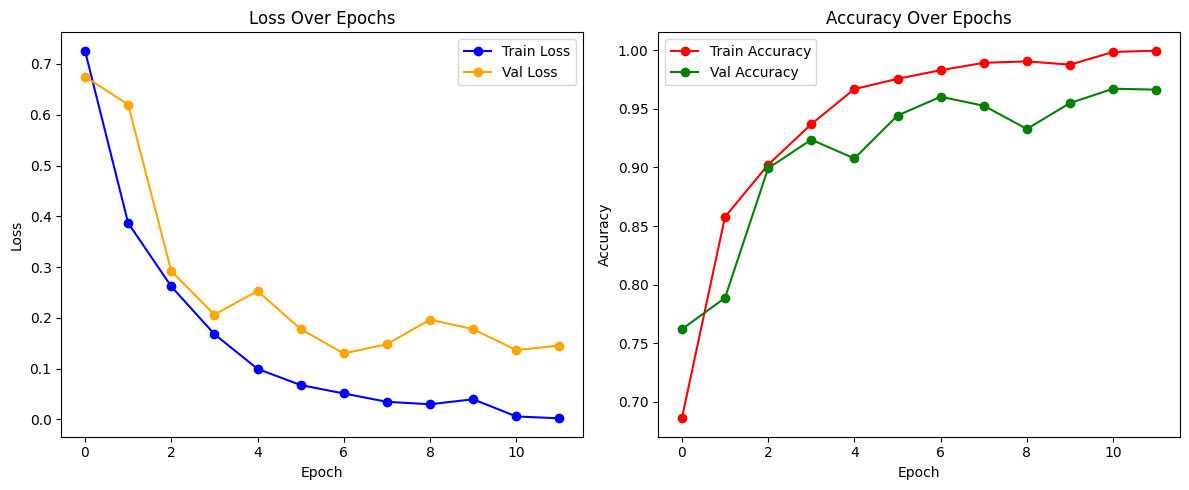

In [18]:
#Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
def merge_brain_tumor_dataset(base_path, output_path):
    
    # Define the class names (subfolder names)
    classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    
    # Create output directory structure
    os.makedirs(output_path, exist_ok=True)
    
    for class_name in classes:
        class_output_dir = os.path.join(output_path, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        print(f"Created directory: {class_output_dir}")
    
    # Copy files from Training and Testing folders
    for folder_type in ['Training', 'Testing']:
        folder_path = os.path.join(base_path, folder_type)
        
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist!")
            continue
            
        print(f"\nProcessing {folder_type} folder...")
        
        for class_name in classes:
            source_dir = os.path.join(folder_path, class_name)
            target_dir = os.path.join(output_path, class_name)
            
            if not os.path.exists(source_dir):
                print(f"Warning: {source_dir} does not exist!")
                continue
            
            # Get all image files from source directory
            image_files = [f for f in os.listdir(source_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            print(f"  {class_name}: Found {len(image_files)} images")
            
            # Copy each image file
            for i, filename in enumerate(image_files):
                source_file = os.path.join(source_dir, filename)
                
                # Add prefix to avoid naming conflicts
                new_filename = f"{folder_type.lower()}_{filename}"
                target_file = os.path.join(target_dir, new_filename)
                
                try:
                    shutil.copy2(source_file, target_file)
                except Exception as e:
                    print(f"Error copying {source_file}: {e}")
            
            print(f"  Copied {len(image_files)} images from {class_name}")
    
    # Print final statistics
    print("\n" + "="*50)
    print("MERGE COMPLETE - Final Statistics:")
    print("="*50)
    
    total_images = 0
    for class_name in classes:
        class_dir = os.path.join(output_path, class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            print(f"{class_name}: {count} images")
            total_images += count
    
    print(f"\nTotal images in merged dataset: {total_images}")
    print(f"Merged dataset saved to: {output_path}")

# Path to dataset ()
dataset_path = "/kaggle/input/brain-tumor-classification-mri"  

output_path = "/kaggle/working/merged_brain_tumor_dataset"

# Run the merge function
merge_brain_tumor_dataset(dataset_path, output_path)

print("\n" + "="*50)
print("Sample files from merged dataset:")
print("="*50)

for class_name in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
    class_dir = os.path.join(output_path, class_name)
    if os.path.exists(class_dir):
        files = os.listdir(class_dir)[:3]  # Show first 3 files
        print(f"\n{class_name} (showing first 3 files):")
        for file in files:
            print(f"  - {file}")

Created directory: /kaggle/working/merged_brain_tumor_dataset/glioma_tumor
Created directory: /kaggle/working/merged_brain_tumor_dataset/meningioma_tumor
Created directory: /kaggle/working/merged_brain_tumor_dataset/no_tumor
Created directory: /kaggle/working/merged_brain_tumor_dataset/pituitary_tumor

Processing Training folder...
  glioma_tumor: Found 826 images
  Copied 826 images from glioma_tumor
  meningioma_tumor: Found 822 images
  Copied 822 images from meningioma_tumor
  no_tumor: Found 395 images
  Copied 395 images from no_tumor
  pituitary_tumor: Found 827 images
  Copied 827 images from pituitary_tumor

Processing Testing folder...
  glioma_tumor: Found 100 images
  Copied 100 images from glioma_tumor
  meningioma_tumor: Found 115 images
  Copied 115 images from meningioma_tumor
  no_tumor: Found 105 images
  Copied 105 images from no_tumor
  pituitary_tumor: Found 74 images
  Copied 74 images from pituitary_tumor

MERGE COMPLETE - Final Statistics:
glioma_tumor: 926 imag

In [52]:
test_path_1 = '/kaggle/working/merged_brain_tumor_dataset'

In [53]:
dataset_path = "/kaggle/working/merged_brain_tumor_dataset"
output_path = "/kaggle/working/merged_brain_tumor_dataset"

# Get file lists for each class
glioma_files = os.listdir(f"{dataset_path}/glioma_tumor")
meningioma_files = os.listdir(f"{dataset_path}/meningioma_tumor") 
no_tumor_files = os.listdir(f"{dataset_path}/no_tumor")
pituitary_files = os.listdir(f"{dataset_path}/pituitary_tumor")

print("Original distribution:")
print(f"glioma_tumor: {len(glioma_files)}")
print(f"meningioma_tumor: {len(meningioma_files)}")
print(f"no_tumor: {len(no_tumor_files)}")
print(f"pituitary_tumor: {len(pituitary_files)}")

# Find minimum class size
min_size = min(len(glioma_files), len(meningioma_files), len(no_tumor_files), len(pituitary_files))
print(f"\nDownsampling all to: {min_size} samples")

# Downsample each class
# Downsample each class
glioma_downsampled = resample(glioma_files, 
                             replace=False,
                             n_samples=min_size,
                             random_state=42)

meningioma_downsampled = resample(meningioma_files, 
                                 replace=False,
                                 n_samples=min_size,
                                 random_state=42)

no_tumor_downsampled = resample(no_tumor_files, 
                               replace=False,
                               n_samples=min_size,
                               random_state=42)

pituitary_downsampled = resample(pituitary_files, 
                                replace=False,
                                n_samples=min_size,
                                random_state=42)

# Keep only the downsampled files (delete the rest)
classes = {
    'glioma_tumor': glioma_downsampled,
    'meningioma_tumor': meningioma_downsampled,
    'no_tumor': no_tumor_downsampled,
    'pituitary_tumor': pituitary_downsampled
}

for class_name, keep_files in classes.items():
    class_dir = f"{dataset_path}/{class_name}"
    all_files = os.listdir(class_dir)
    
    # Delete files that are NOT in the downsampled list
    for filename in all_files:
        if filename not in keep_files:
            file_path = f"{class_dir}/{filename}"
            os.remove(file_path)
    
    remaining = len(os.listdir(class_dir))
    print(f"{class_name}: kept {remaining} files")

print("Done!")


Original distribution:
glioma_tumor: 926
meningioma_tumor: 937
no_tumor: 500
pituitary_tumor: 901

Downsampling all to: 500 samples
glioma_tumor: kept 500 files
meningioma_tumor: kept 500 files
no_tumor: kept 500 files
pituitary_tumor: kept 500 files
Done!


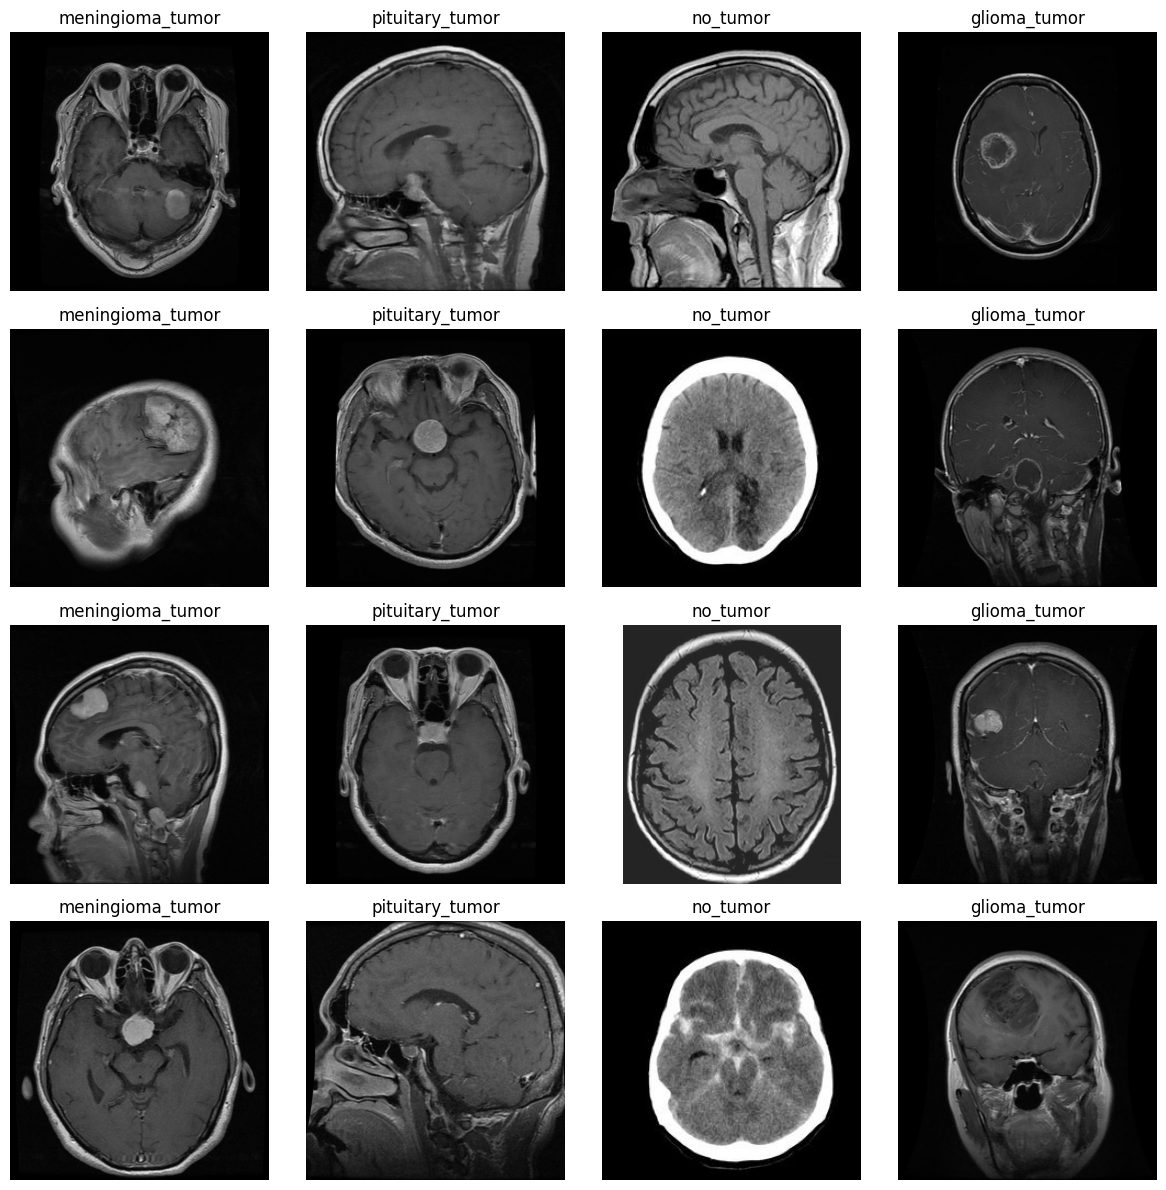

In [54]:
main_folder = r'/kaggle/working/merged_brain_tumor_dataset'
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Get images grouped by folder
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_folder, folder)
    images = [os.path.join(path, img) for img in os.listdir(path) 
              if img.endswith(('.jpg', '.png', '.webp'))]
    random.shuffle(images)  # Shuffle images within each folder
    folder_images[folder] = images

# Round-robin selection
selected_images = []
folder_cycle = cycle(subfolders)  # Infinite loop through folders
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:  # If folder still has images
        selected_images.append(folder_images[folder].pop())

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(os.path.dirname(img_path)))  # Show folder name
plt.tight_layout()
plt.show()

In [55]:
cnn_merged_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_merged_generator = cnn_merged_datagen.flow_from_directory(
        output_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 2000 images belonging to 4 classes.


In [24]:
cnn_predictions = cnn_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step


In [25]:
cnn_result = cnn_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)
print('Loss: ',cnn_result[0])
print('Accuracy: ',cnn_result[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9050 - f1_score: 0.8988 - loss: 0.6842 - precision: 0.9069 - recall: 0.9037
Loss:  0.7615350484848022
Accuracy:  0.8934999704360962


### VGG16 Model

In [56]:
def preprocess_vgg16(x):
    return x/255.0

In [57]:
VGG16_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)
VGG16_train_generator = VGG16_train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.


In [58]:
VGG16_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [59]:
VGG16_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)
VGG16_test_generator = VGG16_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [60]:
VGG16_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [61]:
trained_VGG16_layers = VGG16(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

In [62]:
for layer in trained_VGG16_layers.layers:
    layer.trainable = False

In [63]:
VGG16_model = keras.models.Sequential([
    trained_VGG16_layers,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(4,activation='softmax')
])

In [64]:
VGG16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
VGG16_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
VGG16_history = VGG16_model.fit(
    VGG16_train_generator,
    epochs=20,
    validation_data = VGG16_test_generator,
    callbacks = callbacks
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7236 - loss: 1.1928
Epoch 1: val_loss did not improve from 0.07422
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.7242 - loss: 1.1892 - val_accuracy: 0.9001 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9213 - loss: 0.2069
Epoch 2: val_loss did not improve from 0.07422
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.9213 - loss: 0.2068 - val_accuracy: 0.9169 - val_loss: 0.2070 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9560 - loss: 0.1151
Epoch 3: val_loss did not improve from 0.07422
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.9560 - loss: 0.1151 - val_accuracy: 0.8955 - val_loss: 0.2978 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9641 - loss: 0.0937
Epoch 4: val_loss did not improve from 0.07422
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s

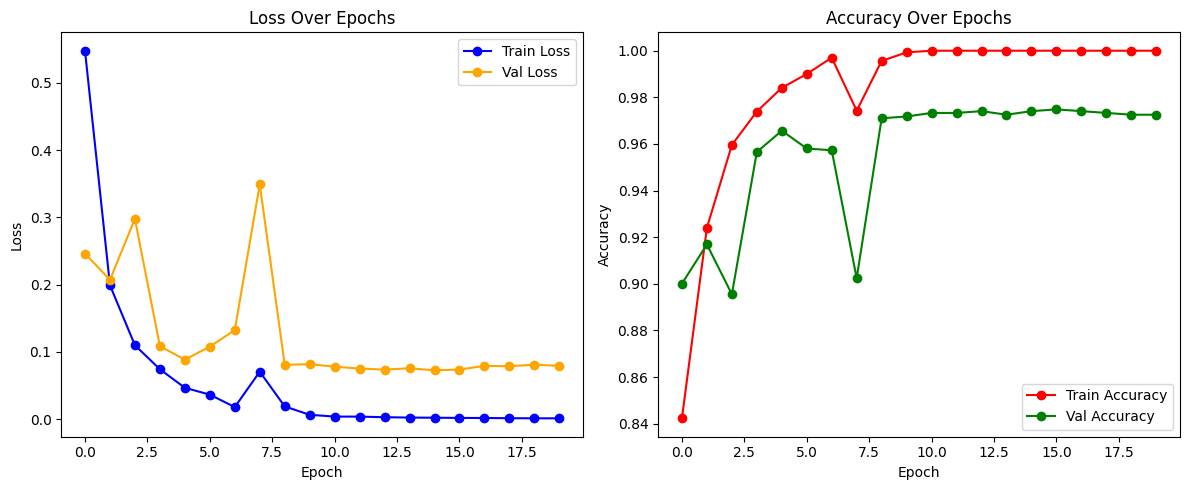

In [67]:
# Plotting training and validation loss and accuracy

plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG16_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG16_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
vgg16_predictions = VGG16_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step


In [69]:
vgg16_result = VGG16_model.evaluate(cnn_merged_generator, batch_size = BATCH_SIZE)
print('Accuracy: ',vgg16_result[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9398 - loss: 0.4743
Accuracy:  0.9330000281333923


### VGG19 Model Building

In [70]:
def preprocess_vgg19(x):
    return x/255.0

In [71]:
VGG19_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg19)
VGG19_train_generator = VGG19_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [72]:
VGG19_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [73]:
VGG19_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg19)
VGG19_test_generator = VGG19_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [74]:
VGG19_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [75]:
trained_VGG19_layers = VGG19(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [76]:
for layer in trained_VGG19_layers.layers:
    layer.trainable=False

In [77]:
VGG19_model = keras.models.Sequential([
    trained_VGG19_layers,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(4,activation='softmax')
])

In [78]:
VGG19_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,448,196 (100.89 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [79]:
VGG19_model.compile(optimizer='Adam',loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [80]:
VGG19_history = VGG19_model.fit(
    VGG19_train_generator,
    epochs=20,
    validation_data = VGG19_test_generator,
    callbacks = callbacks
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6790 - loss: 1.7550
Epoch 1: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.6796 - loss: 1.7494 - val_accuracy: 0.8764 - val_loss: 0.3005 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9173 - loss: 0.2221
Epoch 2: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9172 - loss: 0.2222 - val_accuracy: 0.8863 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9237 - loss: 0.1911
Epoch 3: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.9237 - loss: 0.1909 - val_accuracy: 0.8780 - val_loss: 0.3139 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9581 - loss: 0.1229
Epoch 4: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s

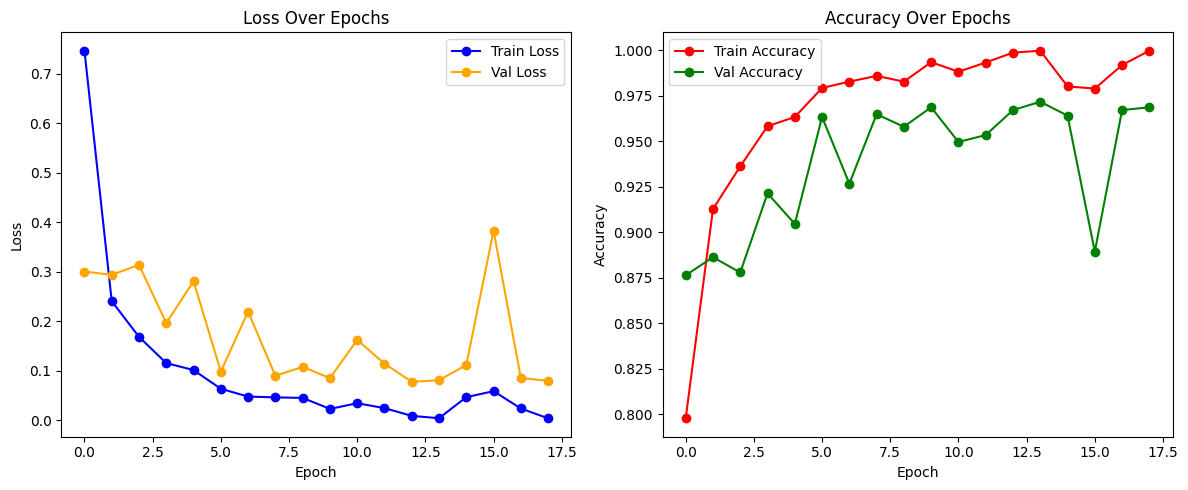

In [81]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(VGG19_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG19_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG19_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG19_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
vgg19_predictions = VGG19_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step


In [85]:
vgg19_result = VGG19_model.evaluate(cnn_merged_generator,batch_size=BATCH_SIZE)
print('Accuracy: ',vgg19_result[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9415 - loss: 0.4506
Accuracy:  0.940500020980835


### ResNet Model Building

In [86]:
def preprocess_resnet(x):
    return x/255.0

In [87]:
ResNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)
ResNet_train_generator = ResNet_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [88]:
ResNet_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [89]:
ResNet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)
ResNet_test_generator = ResNet_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [90]:
ResNet_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [91]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [92]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False

In [93]:
ResNet_model = keras.models.Sequential([
    trained_ResNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])

In [94]:
ResNet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [95]:
ResNet_model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
               metrics=['accuracy']
                    )

In [96]:
ResNet_history = ResNet_model.fit(
        ResNet_train_generator,
        epochs = 20,
        validation_data = ResNet_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7482 - loss: 0.7112
Epoch 1: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 167ms/step - accuracy: 0.7487 - loss: 0.7098 - val_accuracy: 0.9077 - val_loss: 0.2662 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9316 - loss: 0.1978
Epoch 2: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9316 - loss: 0.1977 - val_accuracy: 0.9138 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9506 - loss: 0.1319
Epoch 3: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.9506 - loss: 0.1319 - val_accuracy: 0.9314 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9735 - loss: 0.0833
Epoch 4: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s

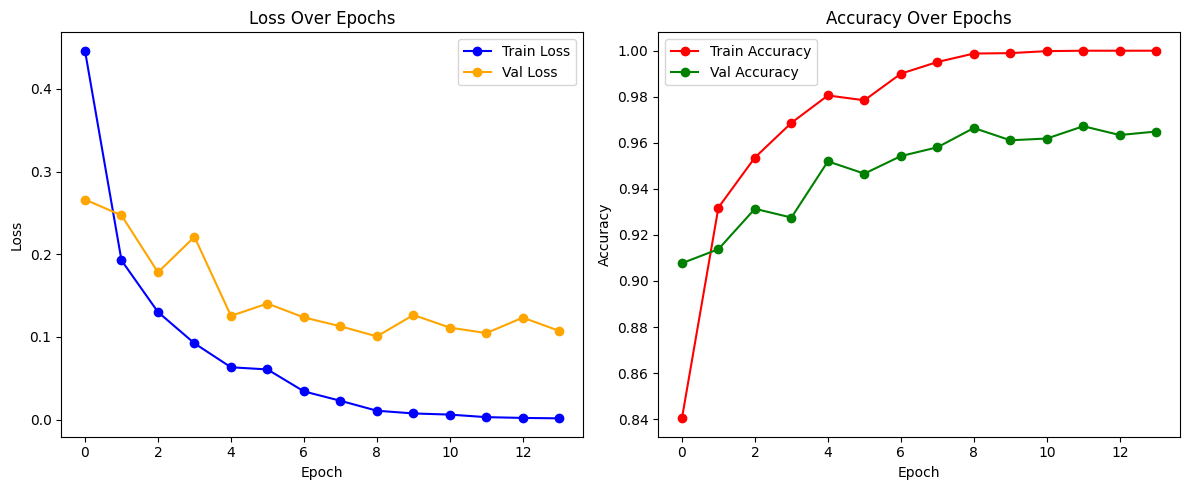

In [98]:
#Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [99]:
resnet_predictions = ResNet_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step


In [101]:
resnet_result = ResNet_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)
print('Accuracy: ',resnet_result[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9758 - loss: 0.1975
Accuracy:  0.9695000052452087


### MobileNet Model Building

In [102]:
def preprocess_mobilenet(x):
    return x/255.0

In [103]:
MobileNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)
MobileNet_train_generator = MobileNet_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [104]:
MobileNet_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [105]:
MobileNet_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenet)
MobileNet_test_generator = MobileNet_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1311 images belonging to 4 classes.


In [106]:
MobileNet_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [107]:
trained_MobileNet_layers = MobileNetV2(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [108]:
for layer in trained_MobileNet_layers.layers:
    layer.trainable = False

In [109]:
MobileNet_model = keras.models.Sequential([
    trained_MobileNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
]) 

In [110]:
MobileNet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [111]:
MobileNet_model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
               metrics=['accuracy']
)

In [112]:
MobileNet_history = MobileNet_model.fit(
        MobileNet_train_generator,
        epochs = 20,
        validation_data = MobileNet_test_generator,
        callbacks = callbacks
        )

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7928 - loss: 0.5370
Epoch 1: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.7932 - loss: 0.5362 - val_accuracy: 0.8741 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9105 - loss: 0.2414
Epoch 2: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.9106 - loss: 0.2412 - val_accuracy: 0.9275 - val_loss: 0.2011 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9433 - loss: 0.1550
Epoch 3: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9433 - loss: 0.1550 - val_accuracy: 0.9237 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9484 - loss: 0.1484
Epoch 4: val_loss did not improve from 0.07241
179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 

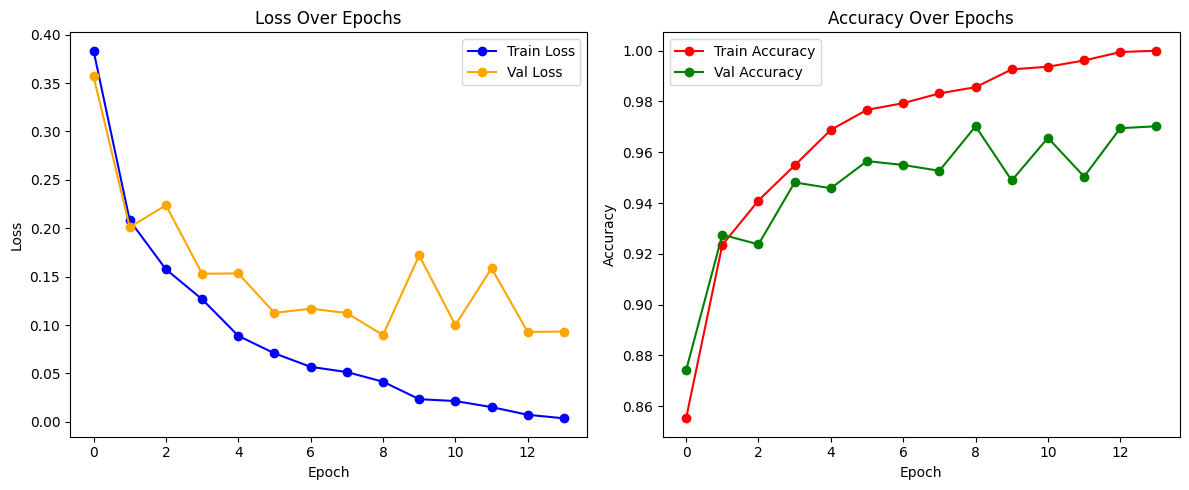

In [113]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(MobileNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(MobileNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(MobileNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(MobileNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [114]:
mobilenet_predictions = MobileNet_model.predict(cnn_merged_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step


In [115]:
mobilenet_result = MobileNet_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)
print('Accuracy: ',mobilenet_result[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9667 - loss: 0.3193
Accuracy:  0.9639999866485596


### EfficientNet Model Building

In [116]:
def preprocess_mobilenet(x):
    return x/255.0

In [117]:
EffNetB3_train_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
EffNetB3_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

In [170]:
EffNetB3_train_generator = EffNetB3_train_datagen.flow_from_directory(
    train_path,
    target_size=(300,300),  
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.


In [171]:
EffNetB3_train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [172]:
EffNetB3_test_generator = EffNetB3_test_datagen.flow_from_directory(
    test_path,
    target_size=(300,300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1311 images belonging to 4 classes.


In [173]:
EffNetB3_test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [174]:
base_effnetb3 = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(300, 300, 3)
)

In [175]:
for layer in base_effnetb3.layers:
    layer.trainable = False

In [176]:
EffNetB3_model = keras.models.Sequential([
    base_effnetb3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax') 
])

In [177]:

EffNetB3_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,035 (42.64 MB)

 Trainable params: 394,500 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [178]:
EffNetB3_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [184]:
EffNetB3_history = EffNetB3_model.fit(
    EffNetB3_train_generator,
    epochs=20,
    validation_data=EffNetB3_test_generator,
    callbacks=callbacks  
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9682 - loss: 0.0881
Epoch 1: val_loss did not improve from 0.04584
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.9682 - loss: 0.0881 - val_accuracy: 0.9664 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9635 - loss: 0.0964
Epoch 2: val_loss did not improve from 0.04584
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9635 - loss: 0.0964 - val_accuracy: 0.9603 - val_loss: 0.1077 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9704 - loss: 0.0815
Epoch 3: val_loss did not improve from 0.04584
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.9704 - loss: 0.0815 - val_accuracy: 0.9695 - val_loss: 0.0738 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9720 - loss: 0.0759
Epoch 4: val_loss did not improve from 0.04584
179/179 ━━━━━━━━━━━━━━━━━━━━

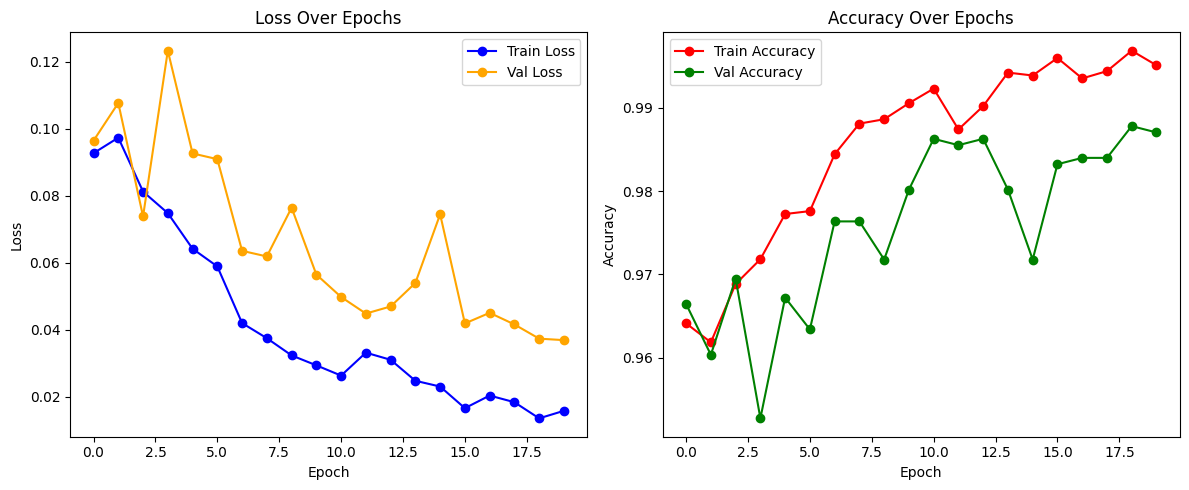

In [188]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(EffNetB3_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(EffNetB3_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(EffNetB3_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(EffNetB3_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [189]:
cnn_merged_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
cnn_merged_generator = cnn_merged_datagen.flow_from_directory(
    output_path,
    target_size=(300, 300),  # Important for EfficientNetB3
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

effnetb3_predictions = EffNetB3_model.predict(cnn_merged_generator)

Found 2000 images belonging to 4 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step


In [190]:
effnetb3_result = EffNetB3_model.evaluate(cnn_merged_generator, batch_size=BATCH_SIZE)
print('Accuracy:', effnetb3_result[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9699 - loss: 0.2527
Accuracy: 0.9700000286102295


### Compare Between Models

In [193]:
models = ['Best CNN', 'Best MobileNetV2', 'Best VGG16', 'Best VGG19', 'Best ResNest50', 'Best EfficientNetB3']

best_train_accuracy = [
    cnn_history.history['accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
    MobileNet_history.history['accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
    VGG16_history.history['accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
    VGG19_history.history['accuracy'][np.argmax(VGG19_history.history['val_accuracy'])],
    ResNet_history.history['accuracy'][np.argmax(ResNet_history.history['val_accuracy'])],
    EffNetB3_history.history['accuracy'][np.argmax(EffNetB3_history.history['val_accuracy'])]
]

best_val_accuracy = [
    cnn_history.history['val_accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
    MobileNet_history.history['val_accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
    VGG16_history.history['val_accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
    VGG19_history.history['val_accuracy'][np.argmax(VGG19_history.history['val_accuracy'])],
    ResNet_history.history['val_accuracy'][np.argmax(ResNet_history.history['val_accuracy'])],
    EffNetB3_history.history['val_accuracy'][np.argmax(EffNetB3_history.history['val_accuracy'])]
]  


In [195]:
history = {
    "CNN": {
        "accuracy": cnn_history.history['accuracy'],
        "val_accuracy": cnn_history.history['val_accuracy'],
        "loss": cnn_history.history['loss'],
        "val_loss": cnn_history.history['val_loss']
    },
    "MobileNetV2": {
        "accuracy": MobileNet_history.history['accuracy'],
        "val_accuracy": MobileNet_history.history['val_accuracy'],
        "loss": MobileNet_history.history['loss'],
        "val_loss": MobileNet_history.history['val_loss']
    },
    "VGG16": {
        "accuracy": VGG16_history.history['accuracy'],
        "val_accuracy": VGG16_history.history['val_accuracy'],
        "loss": VGG16_history.history['loss'],
        "val_loss": VGG16_history.history['val_loss']
    },
    "VGG19": {
        "accuracy": VGG19_history.history['accuracy'],
        "val_accuracy": VGG19_history.history['val_accuracy'],
        "loss": VGG19_history.history['loss'],
        "val_loss": VGG19_history.history['val_loss']
    },
    "ResNet50V2": {
        "accuracy": ResNet_history.history['accuracy'],
        "val_accuracy": ResNet_history.history['val_accuracy'],
        "loss": ResNet_history.history['loss'],
        "val_loss": ResNet_history.history['val_loss']
    },
    "EfficientNetB3": {
        "accuracy": EffNetB3_history.history['accuracy'],
        "val_accuracy": EffNetB3_history.history['val_accuracy'],
        "loss": EffNetB3_history.history['loss'],
        "val_loss": EffNetB3_history.history['val_loss']
    }
}


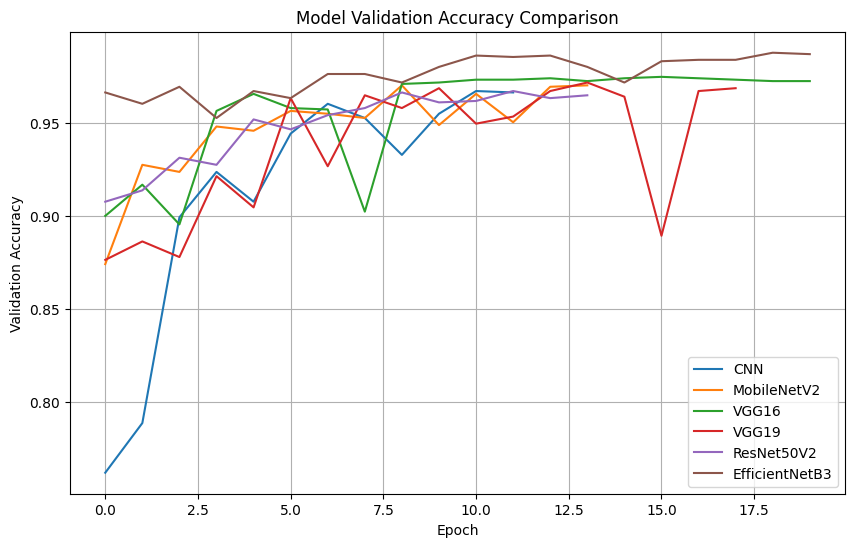

In [196]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_accuracy'], label=model)
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

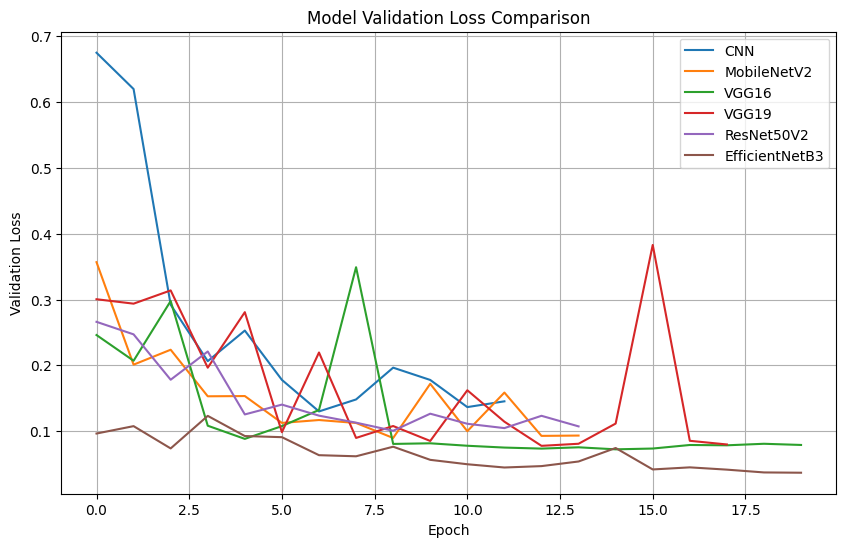

In [197]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_loss'], label=model)
plt.title('Model Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


Models ranked by accuracy:
1. EfficientNetB3: 0.9700
2. ResNet: 0.9695
3. MobileNet: 0.9640
4. VGG19: 0.9405
5. VGG16: 0.9330
6. CNN: 0.8935


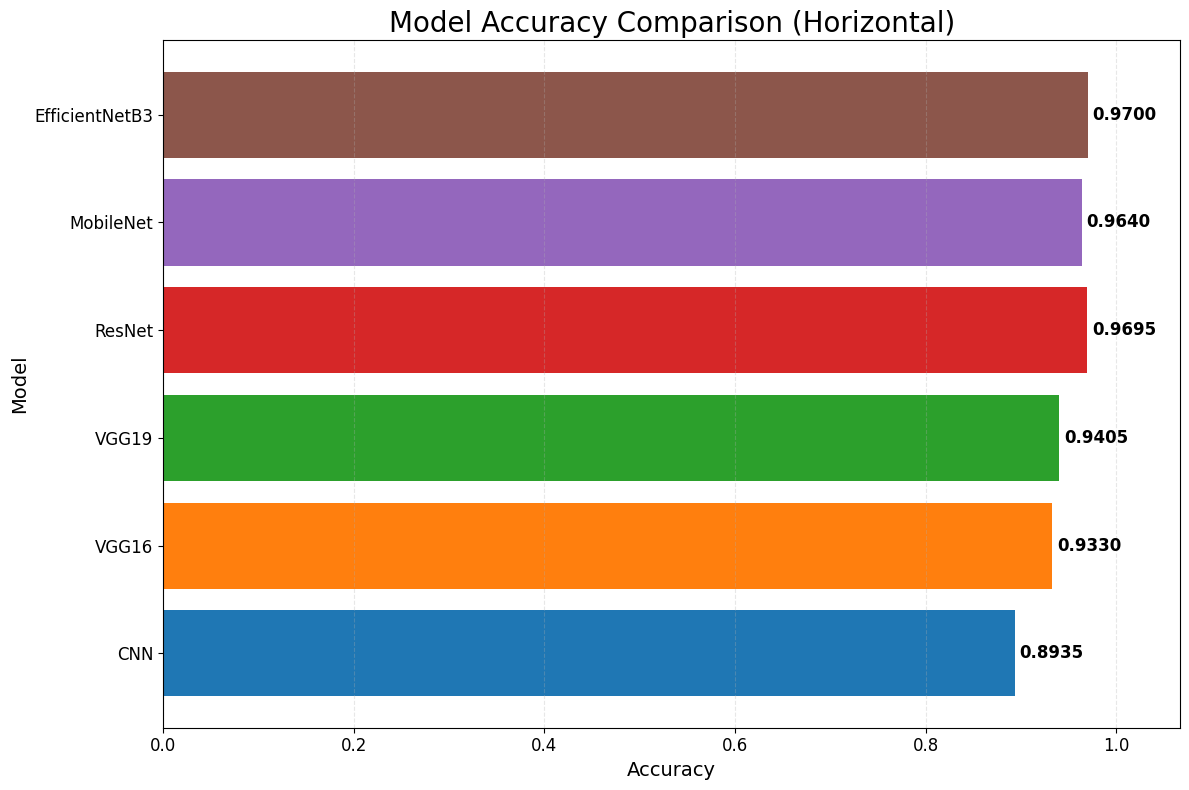

In [198]:
THE_ALL_RESULTS = {
    'CNN': cnn_result[1],
    'VGG16': vgg16_result[1], 
    'VGG19': vgg19_result[1],
    'ResNet': resnet_result[1],
    'MobileNet': mobilenet_result[1],
    'EfficientNetB3': effnetb3_result[1]
}
history = {
    'CNN': cnn_history.history,
    'MobileNetV2': MobileNet_history.history,
    'VGG16': VGG16_history.history,
    'VGG19': VGG19_history.history,
    'ResNet': ResNet_history.history,
    'EfficientNetB3': EffNetB3_history.history
}
print("\nModels ranked by accuracy:")
sorted_results = sorted(THE_ALL_RESULTS.items(), key=lambda x: x[1], reverse=True)
for i, (model, accuracy) in enumerate(sorted_results, 1):
    print(f"{i}. {model}: {accuracy:.4f}")

plt.figure(figsize=(12, 8))
models = list(THE_ALL_RESULTS.keys())
accuracies = list(THE_ALL_RESULTS.values())

bars = plt.barh(models, accuracies, color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

# Add value labels at the end of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.4f}', ha='left', va='center', fontsize=12, fontweight='bold')

plt.title('Model Accuracy Comparison (Horizontal)', fontsize=20)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Set x-axis limits to better show differences
plt.xlim(0, max(THE_ALL_RESULTS.values()) * 1.1)

plt.tight_layout()
plt.show()